### **0. Import libraries**

In [1]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
#from xgboost import XGBRegressor
from scipy.special import huber
import numpy as np
import seaborn as sns
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import HuberRegressor
import patsy
import statsmodels.formula.api as smf
from patsy import dmatrices
RANDOM_STATE = 2023
TEST_SIZE = 0.2
#pip install --pre --extra-index - this for extracting features

In [2]:
os.getcwd()

'/home/ec2-user/fire_capstone/models'

In [3]:
#path='/home/ec2-user/finalish_df_6.csv'
path='final_df_2.csv'

In [4]:
df=pd.read_csv(path)

In [5]:
df.head()

,Unnamed: 0,ZCTA,year_month,ins_1_no_bin_raw,ins_2_add_acres_raw,ins_3_norms,ins_4_add_acres_norms,ins_5_norm_bins_acres,ins_6_bins_raw,zip_pm25,...,percent_pop_male_age_under_5,total_population,percent_bach_deg_grad_new,percent_high_school_grad_new,percent_pop_age_15to19_new,percent_pop_female_age_15to19_new,percent_pop_male_age_10to14_new,percent_pop_male_age_15to19_new,Patient_disease,total_cases
0,0,89010,199101,0.014313,2.171619,2.095820,0.001013,0.011318,24.261588,12.450976,...,2.4,275.6,14.272763,56.603842,13.526364,14.514991,3.99958,8.781446,NaN,NaN
1,1,89010,199102,0.003401,1.473353,0.499474,0.000688,0.007878,16.875655,11.255854,...,2.4,275.6,14.272763,56.603842,13.526364,14.514991,3.99958,8.781446,NaN,NaN
2,2,89010,199103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.130000,...,2.4,275.6,14.272763,56.603842,13.526364,14.514991,3.99958,8.781446,NaN,NaN
3,3,89010,199104,0.024555,4.317860,3.633868,0.002025,0.024022,51.209927,7.899268,...,2.4,275.6,14.272763,56.603842,13.526364,14.514991,3.99958,8.781446,Anxiety,1.0
4,4,89010,199105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.004146,...,2.4,275.6,14.272763,56.603842,13.526364,14.514991,3.99958,8.781446,NaN,NaN


In [6]:
#Understand the data
df.treatment

0         1
1         0
2         0
3         1
4         0
         ..
553235    0
553236    0
553237    0
553238    0
553239    0
Name: treatment, Length: 553240, dtype: int64

In [7]:
df.shape

(553240, 35)

In [8]:
#split yearmonth into year and month
df=df.assign(date=df.loc[:,"year_month"].astype("string").str[0:4].astype("Datetime64").dt.year, month=df.loc[:,"year_month"].astype("string").str[4:])

In [9]:
df.head()

,Unnamed: 0,ZCTA,year_month,ins_1_no_bin_raw,ins_2_add_acres_raw,ins_3_norms,ins_4_add_acres_norms,ins_5_norm_bins_acres,ins_6_bins_raw,zip_pm25,...,percent_bach_deg_grad_new,percent_high_school_grad_new,percent_pop_age_15to19_new,percent_pop_female_age_15to19_new,percent_pop_male_age_10to14_new,percent_pop_male_age_15to19_new,Patient_disease,total_cases,date,month
0,0,89010,199101,0.014313,2.171619,2.095820,0.001013,0.011318,24.261588,12.450976,...,14.272763,56.603842,13.526364,14.514991,3.99958,8.781446,NaN,NaN,1991,01
1,1,89010,199102,0.003401,1.473353,0.499474,0.000688,0.007878,16.875655,11.255854,...,14.272763,56.603842,13.526364,14.514991,3.99958,8.781446,NaN,NaN,1991,02
2,2,89010,199103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.130000,...,14.272763,56.603842,13.526364,14.514991,3.99958,8.781446,NaN,NaN,1991,03
3,3,89010,199104,0.024555,4.317860,3.633868,0.002025,0.024022,51.209927,7.899268,...,14.272763,56.603842,13.526364,14.514991,3.99958,8.781446,Anxiety,1.0,1991,04
4,4,89010,199105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.004146,...,14.272763,56.603842,13.526364,14.514991,3.99958,8.781446,NaN,NaN,1991,05


In [10]:
#drop irrelevant columns
df=df.query("date<2017")
df1=df.drop(['Unnamed: 0','date','elevation_difference','Patient_disease','total_cases'],axis=1)
#df1=df.drop(['Unnamed: 0','date','elevation_difference'],axis=1)


In [11]:

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 513813 entries, 0 to 553215
Data columns (total 32 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   ZCTA                               513813 non-null  int64  
 1   year_month                         513813 non-null  int64  
 2   ins_1_no_bin_raw                   513813 non-null  float64
 3   ins_2_add_acres_raw                513813 non-null  float64
 4   ins_3_norms                        513812 non-null  float64
 5   ins_4_add_acres_norms              513812 non-null  float64
 6   ins_5_norm_bins_acres              513812 non-null  float64
 7   ins_6_bins_raw                     513813 non-null  float64
 8   zip_pm25                           507117 non-null  float64
 9   zip_elevation                      510906 non-null  float64
 10  zip_wspd                           513813 non-null  float64
 11  treatment                          5138

In [12]:
#dfrows_with_nulls=df1.isnull().any(axis=1).sum()
#n=df1.isnull().any(axis=1)
#nan_count = df1.isna().sum(axis = 1)
#nan_count
#df1[n]
rows_with_nulls=df1.isna().sum(axis=0)
with_nulls=df1.isna().sum(axis=1)
print(rows_with_nulls)
print(with_nulls)
nrows_with_missing_values=(df1.isna().any(axis=1).sum())
print(nrows_with_missing_values)
print(df1.shape)

ZCTA                                    0
year_month                              0
ins_1_no_bin_raw                        0
ins_2_add_acres_raw                     0
ins_3_norms                             1
ins_4_add_acres_norms                   1
ins_5_norm_bins_acres                   1
ins_6_bins_raw                          0
zip_pm25                             6696
zip_elevation                        2907
zip_wspd                                0
treatment                               0
year                                    0
households_count                     9753
mean_income_per_household            9753
median_income_per_household          9753
percent_pop_age_10to14               9753
percent_pop_age_5to9                 9753
percent_pop_age_under_5              9753
percent_pop_female_age_10to14        9753
percent_pop_female_age_5to9          9753
percent_pop_female_age_under_5       9753
percent_pop_male_age_5to9            9753
percent_pop_male_age_under_5      

In [13]:
#cols=['zip_pm25','zip_elevation','median_income_per_household','total_population','percent_pop_age_10to14', 'percent_pop_age_5to9','percent_pop_age_under_5','percent_bach_deg_grad_new','percent_high_school_grad_new', 
#       'percent_pop_age_15to19_new']
#for i in cols:
#    df1.loc[:,i]=df1.groupby('year_month')[i].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))


In [14]:
#drop all rows with null values
df1.dropna(inplace=True)
print(df1.shape)

(500488, 32)


In [15]:
#convert zipcode to string
df1.loc[:,'ZCTA']=df1.loc[:,'ZCTA'].astype('string')

In [16]:
#introduce year as string for onehot encoding in the model
df1.loc[:,'month1']=df1.loc[:,'month'].astype('int')
df1.loc[:,'years']=df1.loc[:,'year'].astype('string')

In [17]:
#df1.info()
#df1.loc[:,'year'].nunique()

In [18]:
#select instruments
cols=['year','ins_1_no_bin_raw','ins_2_add_acres_raw', 'ins_3_norms', 'ins_4_add_acres_norms','ins_5_norm_bins_acres','ins_6_bins_raw',]
df1a=df1.loc[:,cols]

In [19]:
#make year_month an index and sort values by year_month
df1.loc[:,"year_month"]=df1.loc[:,"year_month"].astype(int)
df1.loc[:,"year_month1"]=df1.loc[:,"year_month"].astype('int')
df1.sort_values(by=['year_month'],inplace=True)
df1.set_index('year_month', inplace=True)
#df1.loc[:,"year"]=df.loc[:,"year"].astype(float)

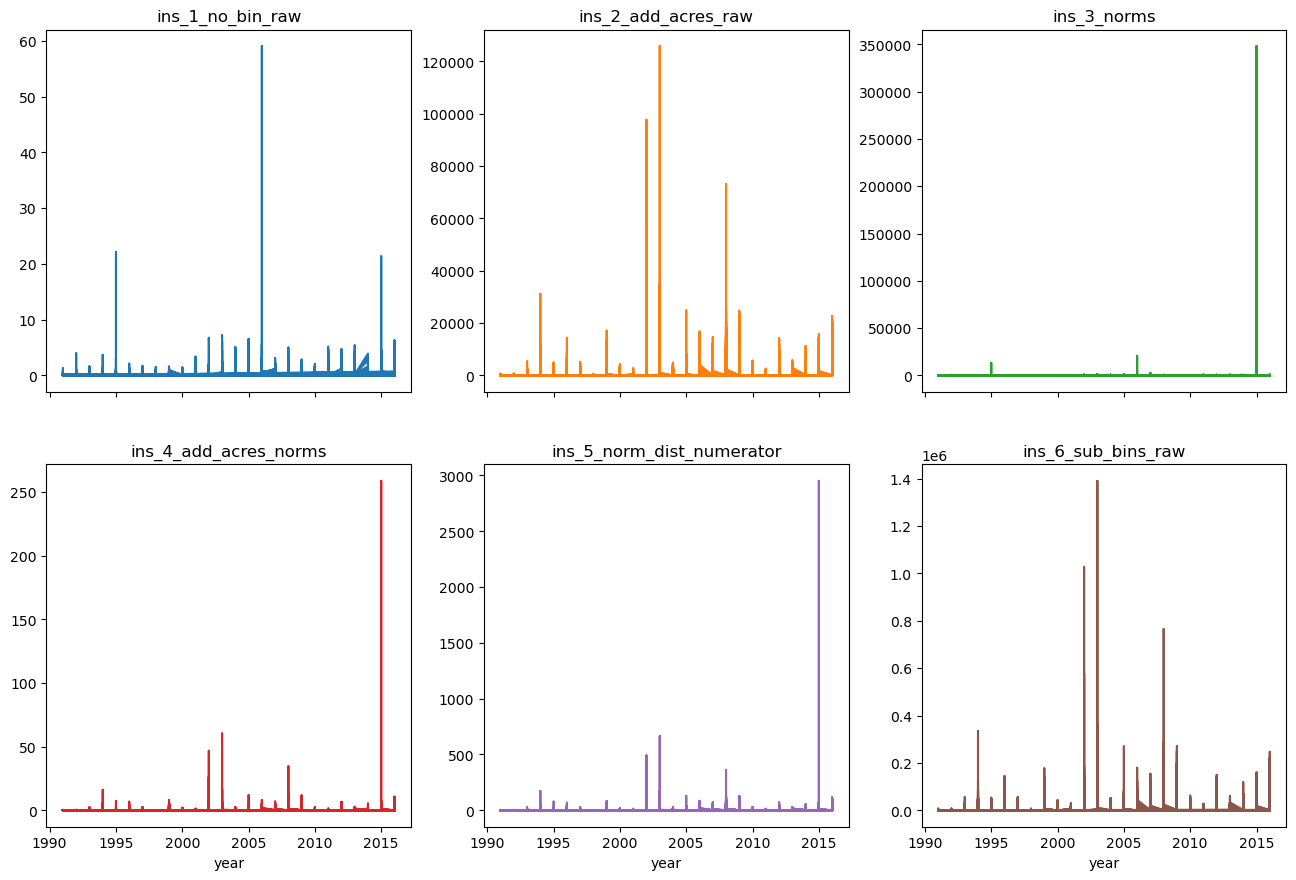

In [20]:
df1a.set_index("year").plot(
    figsize=(16,16),
    subplots=True,
    layout=(3,3),
    sharey=False,
    legend=False,
    title=['ins_1_no_bin_raw','ins_2_add_acres_raw', 'ins_3_norms', 'ins_4_add_acres_norms','ins_5_norm_dist_numerator','ins_6_sub_bins_raw'],
);

In [21]:
#corr_df=df1.corr().drop('ZCTA',axis=1).drop('ZCTA',axis=0)
corr_df=df1.corr()
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

/tmp/ipykernel_5541/4148240826.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)


,ins_1_no_bin_raw,ins_2_add_acres_raw,ins_3_norms,ins_4_add_acres_norms,ins_5_norm_bins_acres,ins_6_bins_raw,zip_pm25,zip_elevation,zip_wspd,treatment,year,households_count,mean_income_per_household,median_income_per_household,percent_pop_age_10to14,percent_pop_age_5to9,percent_pop_age_under_5,percent_pop_female_age_10to14,percent_pop_female_age_5to9,percent_pop_female_age_under_5,percent_pop_male_age_5to9,percent_pop_male_age_under_5,total_population,percent_bach_deg_grad_new,percent_high_school_grad_new,percent_pop_age_15to19_new,percent_pop_female_age_15to19_new,percent_pop_male_age_10to14_new,percent_pop_male_age_15to19_new,month1,year_month1
ins_1_no_bin_raw,1.00,0.34,0.24,0.35,0.34,0.34,0.01,-0.00,0.21,0.32,0.22,0.05,0.09,0.09,0.00,-0.01,-0.02,-0.00,-0.02,-0.03,-0.01,-0.02,0.05,0.02,-0.01,-0.04,-0.03,0.00,-0.04,0.08,0.22
ins_2_add_acres_raw,0.34,1.00,0.03,0.69,0.66,1.00,0.05,0.00,0.08,0.19,0.12,0.02,0.05,0.05,0.00,-0.01,-0.02,-0.00,-0.01,-0.02,-0.00,-0.02,0.03,0.01,-0.01,-0.02,-0.02,0.00,-0.02,0.12,0.12
ins_3_norms,0.24,0.03,1.00,0.75,0.77,0.03,0.00,-0.00,0.01,0.02,0.01,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.01
ins_4_add_acres_norms,0.35,0.69,0.75,1.00,1.00,0.69,0.03,0.00,0.05,0.13,0.08,0.02,0.03,0.03,0.00,-0.00,-0.01,-0.00,-0.01,-0.01,-0.00,-0.01,0.02,0.01,-0.01,-0.02,-0.01,0.00,-0.02,0.08,0.08
ins_5_norm_bins_acres,0.34,0.66,0.77,1.00,1.00,0.66,0.03,0.00,0.05,0.13,0.08,0.02,0.03,0.03,0.00,-0.00,-0.01,-0.00,-0.01,-0.01,-0.00,-0.01,0.02,0.01,-0.01,-0.02,-0.01,0.00,-0.02,0.08,0.08
ins_6_bins_raw,0.34,1.00,0.03,0.69,0.66,1.00,0.05,0.00,0.08,0.19,0.12,0.02,0.05,0.05,0.00,-0.01,-0.02,-0.00,-0.01,-0.02,-0.00,-0.02,0.03,0.01,-0.00,-0.02,-0.02,0.00,-0.02,0.12,0.12
zip_pm25,0.01,0.05,0.00,0.03,0.03,0.05,1.00,-0.41,-0.00,0.02,-0.30,0.41,-0.04,-0.04,0.03,0.02,0.10,-0.02,-0.04,-0.00,-0.01,0.05,0.42,0.02,-0.18,0.08,0.02,-0.03,0.04,0.13,-0.30
zip_elevation,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.41,1.00,-0.27,-0.01,-0.00,-0.40,-0.17,-0.16,0.01,-0.00,-0.06,0.08,0.08,0.04,0.03,0.00,-0.38,-0.10,0.18,0.01,0.09,0.07,0.03,0.00,-0.00
zip_wspd,0.21,0.08,0.01,0.05,0.05,0.08,-0.00,-0.27,1.00,0.15,-0.01,0.14,0.16,0.16,-0.02,0.00,0.05,-0.03,-0.03,0.01,0.01,0.03,0.11,0.15,-0.01,-0.02,-0.04,-0.04,-0.03,-0.04,-0.01
treatment,0.32,0.19,0.02,0.13,0.13,0.19,0.02,-0.01,0.15,1.00,0.25,0.04,0.10,0.09,0.00,-0.01,-0.02,0.00,-0.03,-0.02,-0.00,-0.02,0.04,0.03,-0.01,-0.05,-0.04,0.00,-0.04,0.26,0.25


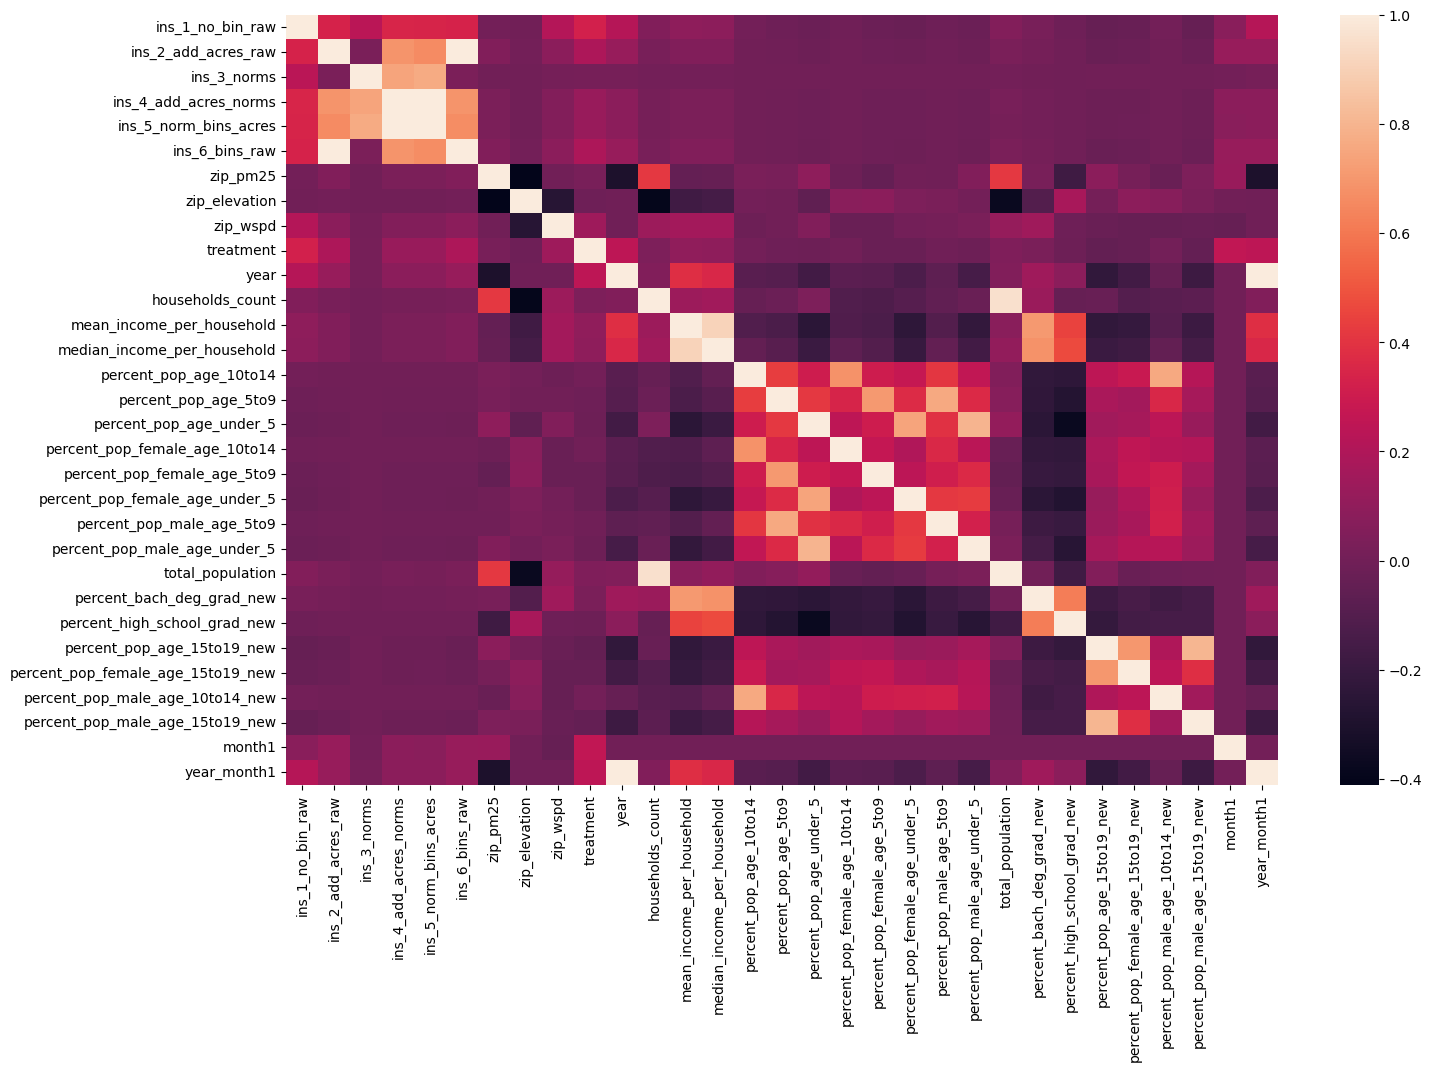

In [22]:
fig, ax = plt.subplots(figsize=(16, 10))
hmap=sns.heatmap(corr_df)

/tmp/ipykernel_5541/3172025710.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.tril(np.ones(corr_df.shape)).astype(np.bool)[0:5,0:5]
/tmp/ipykernel_5541/3172025710.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_lt = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(np.bool))


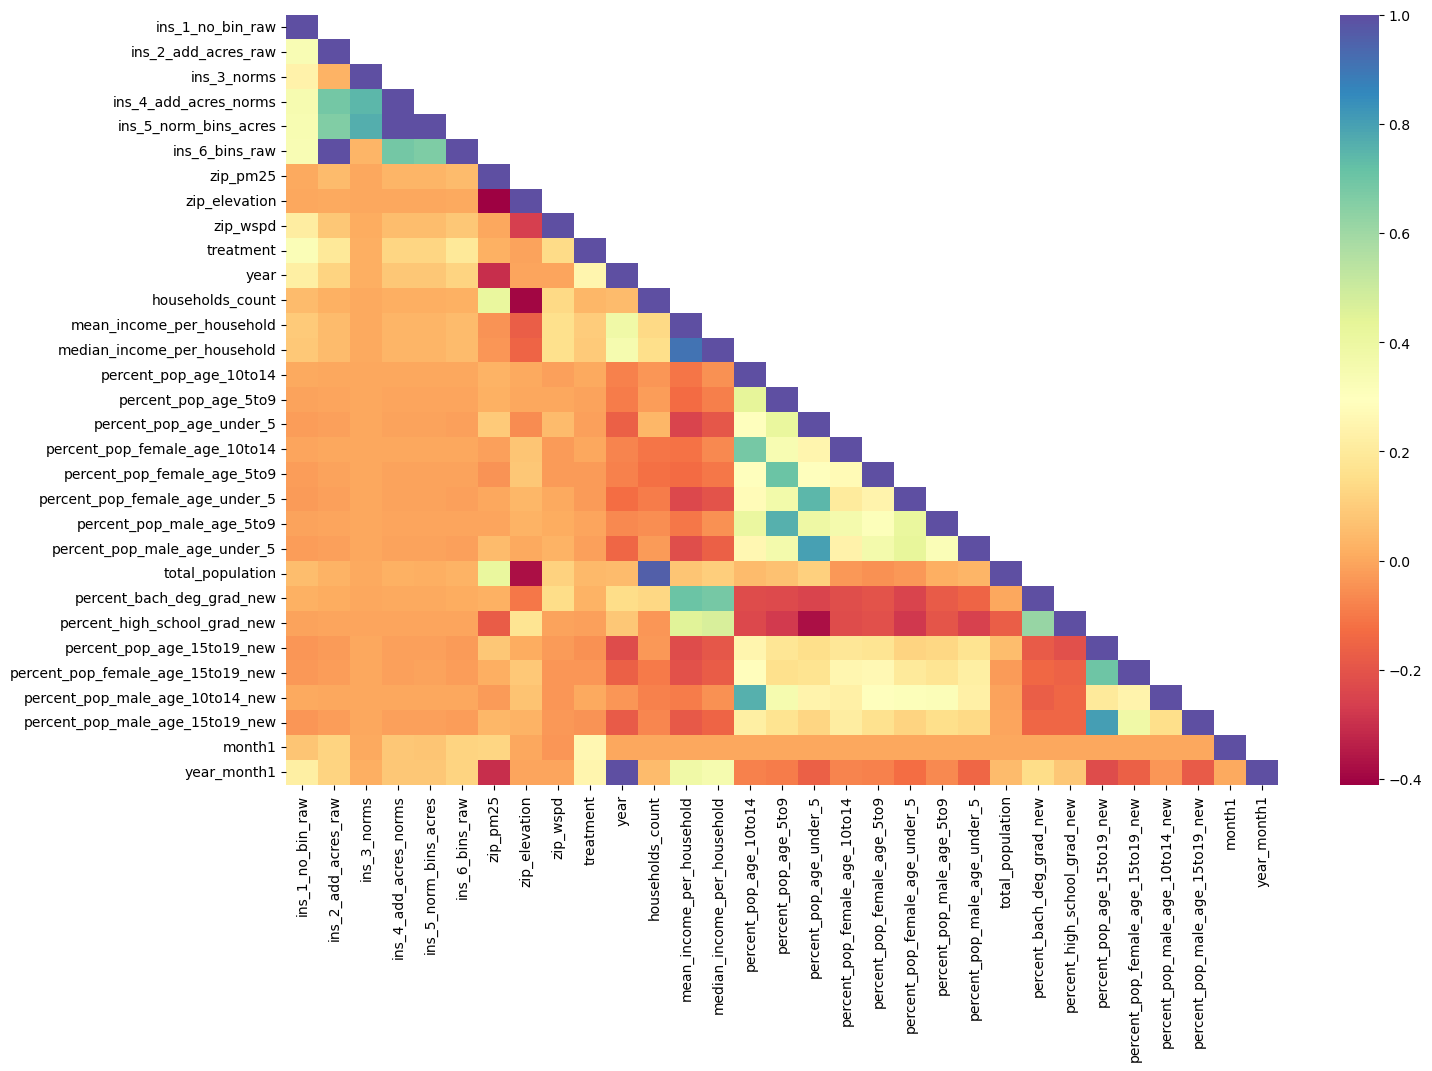

In [23]:
np.tril(np.ones(corr_df.shape)).astype(np.bool)[0:5,0:5]
df_lt = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(np.bool))

fig, ax = plt.subplots(figsize=(16, 10))
hmap=sns.heatmap(df_lt,cmap="Spectral")

<AxesSubplot:ylabel='Frequency'>

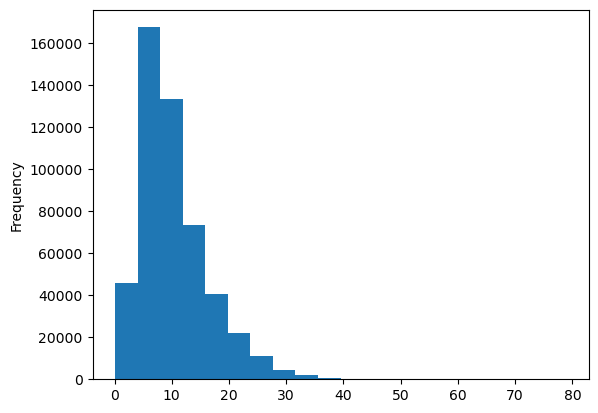

In [24]:
df1.loc[:,"zip_pm25"].plot.hist(bins=20)

In [25]:
#drop all rows with null values
#df1.dropna(inplace=True)
print(df1.shape)

(500488, 34)


In [26]:
df1.sort_index(inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500488 entries, 199101 to 201612
Data columns (total 34 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   ZCTA                               500488 non-null  string 
 1   ins_1_no_bin_raw                   500488 non-null  float64
 2   ins_2_add_acres_raw                500488 non-null  float64
 3   ins_3_norms                        500488 non-null  float64
 4   ins_4_add_acres_norms              500488 non-null  float64
 5   ins_5_norm_bins_acres              500488 non-null  float64
 6   ins_6_bins_raw                     500488 non-null  float64
 7   zip_pm25                           500488 non-null  float64
 8   zip_elevation                      500488 non-null  float64
 9   zip_wspd                           500488 non-null  float64
 10  treatment                          500488 non-null  int64  
 11  year                              

## Stage 1 Model

In [35]:

#identify the x and y variables/columns
instrument = "ins_2_add_acres_raw"

#replace any of the instruments in the xvar below to create a new xvar and run the function

xvar=[instrument, 'zip_elevation', 'zip_wspd', 'year', 'households_count',
       'mean_income_per_household', 'median_income_per_household',
       'percent_pop_age_10to14', 'percent_pop_age_5to9',
       'percent_pop_age_under_5', 'percent_pop_female_age_10to14',
       'percent_pop_female_age_5to9', 'percent_pop_female_age_under_5',
       'percent_pop_male_age_5to9', 'percent_pop_male_age_under_5',
       'total_population', 'percent_bach_deg_grad_new',
       'percent_high_school_grad_new', 'percent_pop_age_15to19_new',
       'percent_pop_female_age_15to19_new', 'percent_pop_male_age_10to14_new',
       'percent_pop_male_age_15to19_new', 'ZCTA','month','treatment']



#xvar1=['ins_1_no_bin_raw','zip_elevation','zip_wspd', 'year','mean_income_per_household','percent_pop_age_10to14', 'percent_pop_age_5to9','percent_pop_age_under_5','percent_bach_deg_grad_new', 
#       'percent_pop_age_15to19_new','month','ZCTA']

#xvar1=['ins_1_no_bin_raw','zip_elevation','zip_wspd', 'year','median_income_per_household','total_population','percent_pop_age_10to14', 'percent_pop_age_5to9','percent_pop_age_under_5','percent_bach_deg_grad_new','percent_high_school_grad_new', 
#       'percent_pop_age_15to19_new','interaction',]
#xvar1=['zip_pm25','ins_1_no_bin_raw','zip_elevation','zip_wspd', 'year','median_income_per_household','total_population','percent_pop_age_10to14', 'percent_pop_age_5to9','percent_pop_age_under_5','percent_bach_deg_grad_new','percent_high_school_grad_new', 
#       'percent_pop_age_15to19_new','month','ZCTA']

xvar1=['zip_pm25',instrument,'zip_elevation','zip_wspd', 'year','median_income_per_household','month','ZCTA','treatment']

yvar=['zip_pm25']


X=(df1.loc[:,xvar1])
y=(df1.loc[:,yvar])

In [36]:
# save the model to disk
#filename = 'Baseline_Regresison_model_04122023.sav'
#joblib.dump(lr, filename)

# Stage 1 Models

In [37]:
df2=df1.loc[:,xvar1]

In [38]:
df2.loc[:,'month']=df2.loc[:,'month'].astype(int)
df2.loc[:,'ZCTA']=df2.loc[:,'ZCTA'].astype(int)

In [39]:
#formula='zip_pm25 ~ ins_1_no_bin_raw + zip_elevation + zip_wspd + year + median_income_per_household + percent_pop_age_10to14 + percent_pop_age_5to9 + percent_pop_age_under_5 + percent_bach_deg_grad_new + percent_high_school_grad_new + percent_pop_age_15to19_new + month + C(ZCTA) + C(month)+ ins_1_no_bin_raw:C(month):C(ZCTA)'
formula=f'zip_pm25 ~ {instrument} + treatment + zip_elevation + year + median_income_per_household + C(ZCTA) + C(month)+ {instrument}:C(month):C(ZCTA):treatment + {instrument}:treatment'
y, X = dmatrices(formula, data=df2, return_type='dataframe')

In [57]:
3+3

6

In [ ]:
mod=sm.OLS(y,X)


In [50]:
import mkl
mkl.set_num_threads(64)

32

In [51]:
res=mod.fit()

In [58]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               zip_pm25   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     66.13
Date:                Sat, 15 Apr 2023   Prob (F-statistic):               0.00
Time:                        16:18:38   Log-Likelihood:            -1.2657e+06
No. Observations:              500488   AIC:                         2.573e+06
Df Residuals:                  479807   BIC:                         2.803e+06
Df Model:                       20680                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [53]:
prediction=res.predict(X)

In [54]:
with open(f'{instrument}.txt', 'w') as f:
    f.write(str(res.summary().as_text()))

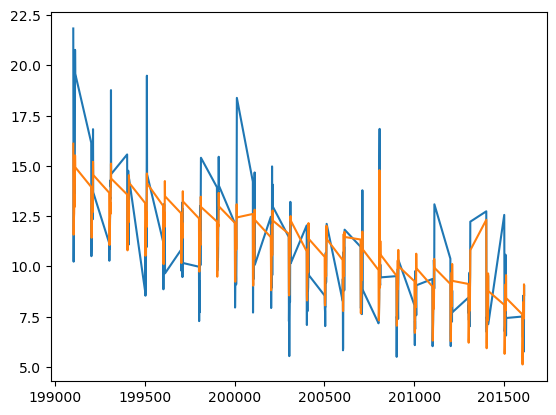

In [55]:
plt.plot(df2.groupby('year_month').mean().index,df2.groupby('year_month').mean()['zip_pm25'])
plt.plot(df2.groupby('year_month').mean().index,prediction.groupby(prediction.index).mean())

In [ ]:
plt.plot(df2.groupby('year_month').mean().index,df2.groupby('year_month').mean()['zip_pm25'])
plt.plot(df2.groupby('year_month').mean().index,prediction.groupby(prediction.index).mean())